# EXP 14 Movielens 영화 추천 실습 


* 이번 시간엔 추천 시스템, CSR Matrix이 무엇인지 배워보고, MF 모델을 이용해 스포티파이에서 발생한 데이터를 가져와 전처리 해 보고, 유저가 좋아하는 특정 아티스트와 유사한 다른 아티스트를 추천하는 추천 시스템 모델을 만들어봤습니다. 


* 예제에서 배운걸 토대로 영화를 추천해 주는 모델을 만들어봅니다. 




---



# 루브릭 평가 기준 


| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. CSR matrix가 정상적으로 만들어졌다. | 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다. |
| 2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다. | 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다. |
| 3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다. | MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다. |




----




# 목차 


## 1. 데이터 및 모듈 불러오기


## 2. 데이터 불러오기


## 3. 데이터 전처리 


## 4. CSR matrix 만들기 


## 5. 모델 구성 및 학습 


## 6. 모델 검증 


## 후기! 


## 🖇️참고페이지 




---




# 1. 데이터 및 모듈 불러오기


* 이번 프로젝트에 필요한 데이터와 모듈을 불러옵니다. 
* LMS 클라우드 이용시, Movielens 데이터를 따로 다운로드 받을 필요는 없습니다. 

## &nbsp;&nbsp; 1-1 데이터 불러오기 


* Cloud Storage에 미리 업로드된 ml-1m폴더 내 파일을 심볼릭 링크로 개인 storage에 연결해 줍니다. 

* 아래 코드를 셀에 입력해주면, 데이터 준비가 완료됩니다.


In [387]:
# $ mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
# $ ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m

## &nbsp;&nbsp; 1-2 모듈 불러오기


* 이번시간에 필요한 모듈을 가져옵니다. 

In [388]:
import os
import numpy as np
import pandas as pd
from implicit.als import AlternatingLeastSquares

# csr_matrix 
from scipy.sparse import csr_matrix
# als 모델 
from implicit.als import AlternatingLeastSquares




---




# 2. 데이터 불러오기


* 데이터셋을 활용하기 전에, 데이터셋에 대해 알아봅니다. 
* pandas를 활용해 데이터를 열어봅니다. 

## &nbsp;&nbsp; 2-1 데이터셋에 대해 알아보기 


* 이번시간에 사용해 볼 데이터셋은 [Movielens 데이터](https://grouplens.org/datasets/movielens/) 입니다. readme 파일을 통해 데이터셋에 대해 알아봅시다. 1-1 항목에서 폴더를 만들고, 데이터를 불러온 다음 폴더 안을 확인 해 봤습니다.   
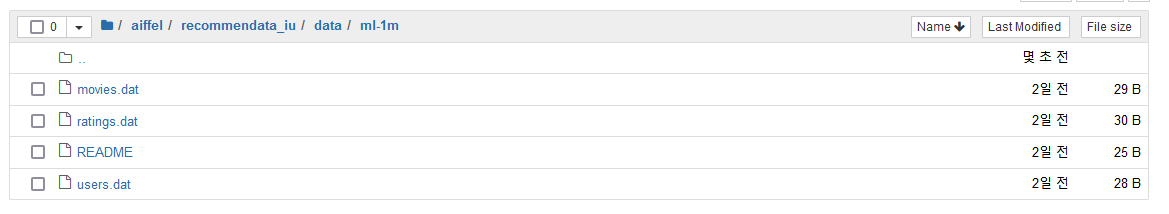

* 이번 데이터셋에는 약 3,900편의 영화에 대한 1,000,209개의 익명으로 매겨진 등급이 포함되어있습니다. 
    2000년도에 MovieLens에 가입한 6,040명의 사용자에 대한 데이터셋 입니다. 미네소타 대학교에서 만들어졌다 하네요! 
    
---

### RATINGS FILE 설명

* 영화 리뷰 별점이 포함되어있는 파일. 
* `::`를 기준으로 데이터가 나눠져 있고, 각 컬럼 명은 ``UserID::MovieID::Rating::Timestamp`` 로 구성되어 있습니다. 
* userId 는 1 에서 6040까지, Movie ID는 1에서 3952까지. 
* 등급은 별 5개 척도로 이루어집니다. (별점 등급만 해당됨)
* 타임스탬프는 time(2)에 의해 반환된 에포크 이후 초 단위로 표시됩니다.
* 각 사용자는 최소 20개의 평가를 가지고 있습니다. 

----

### USERS FILE 설명 

* 파일 그대로 사용자의 데이터가 담겨있는 파일. 
* `::`를 기준으로 데이터가 나눠져 있고, 각 컬럼 명은 `UserID::Gender::Age::Occupation::Zip-code` 로 구성되어 있습니다.
* Gender : 남성은 "M", 여성은 "F"로 표기
* Age : 연령의 범위는 다음과 같습니다.
    *  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"
    
* Occupation : 직업..? 사용자의 직업 같은데, 번호와 분류 기준은 다음과 같습니다.
    *  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"
    

---


### MOVIES FILE  설명
* `::`를 기준으로 데이터가 나눠져 있고, 각 컬럼 명은 `MovieID::Title::Genres` 로 구성되어 있습니다.
* Title : IMDB에서 제공하는 제목과 동일합니다(출시 연도 포함)   
        ex ) Toy Story (1995)
* Genres : 영화의 장르. 
    * Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western
    
- 일부 MovieID는 실수로 중복되어 영화와 일치하지 않습니다.
- 영화는 대부분 손으로 입력하기 때문에 오류 및 불일치가 있을 수 있습니다.

- 파일을 불러와 확인 해 봅시다:D 

In [389]:
# 파일 경로 지정 

movie_file = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
ratings_flie = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
users_flie = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/users.dat'

# col_names 지정 
# readme의 설명대로 컬럼 이름을 정해줬습니다. 
movie_col = ['MovieID','Title','Genres']
ratings_col = ['UserID','MovieID','Rating','Timestamp']
users_col = ['UserID','Gender','Age','Occupation','Zip-code']

In [390]:
# movies.dat 파일 불러오기 
# 각 데이터가 :: 를 기준으로 나눠져 있기 때문에, sep='::'로 주어야 표에 잘 나타납니다. 
# encoding = 'ISO-8859-1' 을 이용해 타이틀이 출력되지 않는 부분을 해결하였다. 
movie = pd.read_csv(movie_file, sep='::', names= movie_col, engine='python', encoding = 'ISO-8859-1' )    

movie.head(10)


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [391]:
# ratings.dat 파일 불러오기 
# 각 데이터가 :: 를 기준으로 나눠져 있기 때문에, sep='::'로 주어야 표에 잘 나타납니다. 

ratings = pd.read_csv(ratings_flie, sep='::', names= ratings_col,  engine='python')      
ratings.head(10)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [392]:
# users.dat 파일 불러오기 
# 각 데이터가 :: 를 기준으로 나눠져 있기 때문에, sep='::'로 주어야 표에 잘 나타납니다. 

users = pd.read_csv(users_flie, sep='::', names= users_col,  engine='python')      
users.head(10)


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


* pandas를 이용해 각 파일의 내용을 확인 해 볼 수 있었습니다. 
* (전처리 과정에선 노드에 있던 코드를 이용하겠습니다.) 




---




# 3. 데이터 전처리 및 분석, 추가 


* Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

* 데이터 전처리 과정을 따라가 봅시다. 
* 데이터를 조건에 맞게 분석 해 보고, 내가 선호하는 영화 5가지를 골라 rating에 추가합니다. 

## &nbsp;&nbsp; 3-1 데이터 전처리 

* 노드상의 데이터 전처리 방법을 따라가면서, 데이터를 전처리 해 줍니다. 

In [393]:
#ratings.dat 파일 불러오기  

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [394]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [395]:
# 불필요한 timestamp 를 없앱니다. 
del ratings['timestamp']

In [396]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [397]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [398]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head(10)

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [399]:
# 용이한 검색을 위해 제목 문자열을 소문자로 바꿔줍니다.
movies['title'] = movies['title'].str.lower()
movies.head()

,movie_id,title,genre
0,1,toy story (1995),Animation|Children's|Comedy
1,2,jumanji (1995),Adventure|Children's|Fantasy
2,3,grumpier old men (1995),Comedy|Romance
3,4,waiting to exhale (1995),Comedy|Drama
4,5,father of the bride part ii (1995),Comedy


# &nbsp;&nbsp; 3-2 내가 선호하는 영화 5가지 추가해보기 


* 영화 제목과 장르를 ratings에 합쳐주기 전에 내 정보를 추가해 봅시다. 
* 우선, 영화 제목에 원하는 영화가 있는지 검색해 보겠습니다. 
* 그 다음, user_id를 만들어, ratings에 추가해 주겠습니다. 

### &nbsp;&nbsp;&nbsp;&nbsp; 3-2-1 Movies 에서 영화 찾아보기!

* 선호 영화가 데이터셋에 있는지 검색 해 봅시다. 
* `.str.contains` 를 사용해서 출력해보겠습니다. 

In [400]:
# 특정 년도의 영화를 찾아볼까요? 
# 2000 년대 이후의 영화는 없나봅니다 ㅎㅎ.. 
movies[movies['title'].str.contains('\(1999\)')]

,movie_id,title,genre
2166,2235,one man's hero (1999),Drama|War
2367,2436,tea with mussolini (1999),Comedy
2376,2445,at first sight (1999),Drama
2377,2446,in dreams (1999),Thriller
2378,2447,varsity blues (1999),Comedy|Drama
...,...,...,...
3797,3867,all the rage (a.k.a. it's the rage) (1999),Drama
3824,3894,solas (1999),Drama
3832,3902,goya in bordeaux (goya en bodeos) (1999),Drama
3837,3907,"prince of central park, the (1999)",Drama


In [401]:
# 검색 조건에 영화 제목 말고도 장르도 함께 붙여 출력해봤습니다. 
# & = and 

movies[movies['title'].str.contains('jungle book')]

,movie_id,title,genre
358,362,"jungle book, the (1994)",Adventure|Children's|Romance
1500,1538,"second jungle book: mowgli & baloo, the (1997)",Adventure|Children's
2009,2078,"jungle book, the (1967)",Animation|Children's|Comedy|Musical


In [402]:
movies[movies['title'].str.contains('alice') & movies['genre'].str.contains('Animation') ]

,movie_id,title,genre
1019,1032,alice in wonderland (1951),Animation|Children's|Musical


In [403]:
movies[movies['title'].str.contains('home alone') ]

,movie_id,title,genre
582,586,home alone (1990),Children's|Comedy
1659,1707,home alone 3 (1997),Children's|Comedy
2884,2953,home alone 2: lost in new york (1992),Children's|Comedy


In [404]:
movies[movies['title'].str.contains('sister act') ]

,movie_id,title,genre
3178,3247,sister act (1992),Comedy|Crime
3179,3248,sister act 2: back in the habit (1993),Comedy


### &nbsp;&nbsp;&nbsp;&nbsp; 3-2-2 사용자 초기 정보 셋팅!


* movie 검색을 통해 원하는 선호하는 영화 5개를 찾았습니다. 
* user_id와 영화 리스트를 ratings에 추가해 주겠습니다. 
* 값을 넣어 추가 해야 할 컬럼은 `user_id, movie_id, counts` 입니다.


In [405]:
# 선호하는 영화의 id를 list에 저장해 주겠습니다. 
my_movie = [ 2078, 586, 1032, 3247, 3248 ]

# user_id 
# 'gy_jeong'이라는 user_id가 좋아하는 영화와, 별점 값을 지정 해 주겠습니다. 
# 별점은 전부 좋아하는 값이므로 5점을 주겠습니다(사심)
my_list = pd.DataFrame({'user_id': ['gy_jeong']*5, 'movie_id': my_movie, 'counts':[5.0]*5})

if not ratings.isin({'user_id':['gy_jeong']})['user_id'].any():  # user_id에 'gy_jeong'이라는 데이터가 없다면
    ratings = ratings.append(my_list)                           # 위에 임의로 만든 my_list 데이터를 추가해 줍니다. 

ratings.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,counts
1000203,6040,1090,3.0
1000205,6040,1094,5.0
1000206,6040,562,5.0
1000207,6040,1096,4.0
1000208,6040,1097,4.0
0,gy_jeong,2078,5.0
1,gy_jeong,586,5.0
2,gy_jeong,1032,5.0
3,gy_jeong,3247,5.0
4,gy_jeong,3248,5.0


In [406]:
# 영화 제목을 보기 위해 영화 제목과 장르가 들어있는 movies를 ratings에 추가해줍니다. 
# pandas merge() 메소드를 사용해 합쳐주겠습니다. 

ratings = pd.merge(ratings, movies)
ratings.tail(10)

,user_id,movie_id,counts,title,genre
836473,5494,3530,4.0,smoking/no smoking (1993),Comedy
836474,5556,2198,3.0,modulations (1998),Documentary
836475,5949,2198,5.0,modulations (1998),Documentary
836476,5675,2703,3.0,broken vessels (1998),Drama
836477,5717,2258,4.0,master ninja i (1984),Action
836478,5851,3607,5.0,one little indian (1973),Comedy|Drama|Western
836479,5854,3026,4.0,slaughterhouse (1987),Horror
836480,5854,690,3.0,"promise, the (versprechen, das) (1994)",Romance
836481,5938,2909,4.0,"five wives, three secretaries and me (1998)",Documentary
836482,5948,1360,5.0,identification of a woman (identificazione di ...,Drama


* id에 맞게 잘 합쳐졌나 확인 해 보겠습니다.

In [407]:
# movie_id 1 은 Toy Story (1995) 입니다. 

test1 = ratings[ratings['movie_id'] == 1 ]
test1.head(5)

,user_id,movie_id,counts,title,genre
38620,1,1,5.0,toy story (1995),Animation|Children's|Comedy
38621,6,1,4.0,toy story (1995),Animation|Children's|Comedy
38622,8,1,4.0,toy story (1995),Animation|Children's|Comedy
38623,9,1,5.0,toy story (1995),Animation|Children's|Comedy
38624,10,1,5.0,toy story (1995),Animation|Children's|Comedy


In [408]:
# movie_id 10 은 GoldenEye (1995) 입니다. 

test2 = ratings[ratings['movie_id'] == 10 ]
test2.head(5)

,user_id,movie_id,counts,title,genre
486274,13,10,3.0,goldeneye (1995),Action|Adventure|Thriller
486275,18,10,5.0,goldeneye (1995),Action|Adventure|Thriller
486276,19,10,5.0,goldeneye (1995),Action|Adventure|Thriller
486277,22,10,3.0,goldeneye (1995),Action|Adventure|Thriller
486278,36,10,4.0,goldeneye (1995),Action|Adventure|Thriller


In [409]:
# 내가 입력한 정보도 제대로 들어갔는지도 확인해봅시다:D 
test3 = ratings[ratings['user_id'] == 'gy_jeong' ]
test3.tail(10)

,user_id,movie_id,counts,title,genre
360523,gy_jeong,586,5.0,home alone (1990),Children's|Comedy
373101,gy_jeong,2078,5.0,"jungle book, the (1967)",Animation|Children's|Comedy|Musical
417674,gy_jeong,1032,5.0,alice in wonderland (1951),Animation|Children's|Musical
442172,gy_jeong,3247,5.0,sister act (1992),Comedy|Crime
716793,gy_jeong,3248,5.0,sister act 2: back in the habit (1993),Comedy


### &nbsp;&nbsp;&nbsp;&nbsp; 3-2-3 인덱싱!


* 혼자만 눈에 띄는 user_id를 다른것과 동일하게 숫자로 바꿔주는 작업을 진행합니다.


- `pandas.DataFrame.unique()`
    - 특정 컬럼에 포함된 유니크한 데이터만 모아주는 메소드
    - 인덱싱 작업에 매우매우 유용함!

In [410]:
# user_unique -> 유저 수 
# movie_unique -> 영화 수량 
user_unique = ratings['user_id'].unique()
movie_unique = ratings['title'].unique()

user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [411]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드입니다. 
# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 

temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data
else:
    print('user_id column indexing Fail!!')

temp_movie_data = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('title column indexing OK!!')
    ratings['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

ratings

user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,counts,title,genre
0,0,1193,5.0,0,Drama
1,1,1193,5.0,0,Drama
2,2,1193,4.0,0,Drama
3,3,1193,4.0,0,Drama
4,4,1193,5.0,0,Drama
...,...,...,...,...,...
836478,1621,3607,5.0,3623,Comedy|Drama|Western
836479,3481,3026,4.0,3624,Horror
836480,3481,690,3.0,3625,Romance
836481,4159,2909,4.0,3626,Documentary


* 이렇게 전처리 과정이 끝났습니다. 데이터셋을 분석 해 보고, 본격적으로 모델 생성, 학습에 들어가겠습니다.

## &nbsp;&nbsp; 3-3 분석해 봅시다!


* 가져온 데이터를 한번 분석 해 봅시다! 
* `pandas.DataFrame.nunique()` 를 이용해 특정 컬럼에 포함된 유니크한 데이터의 개수를 알아봅니다! 
    - 유일한 값의 개수를 확인할 수 있는 기능을 갖고있습니다. 

### &nbsp;&nbsp;&nbsp;&nbsp; 3-3-1 ratings에 있는 유니크한 영화 개수


In [412]:
# 영화 개수! movie_id  
ratings['movie_id'].nunique()

3628

### &nbsp;&nbsp;&nbsp;&nbsp; 3-3-2 ratings에 있는 유니크한 사용자 수

In [413]:
# 유저 수
ratings['user_id'].nunique()

6040

### &nbsp;&nbsp;&nbsp;&nbsp; 3-3-3 가장 인기 있는 영화 30개(인기순)

* 인기 있는 영화를 별점이 제일 높은 영화로 설정해서 가장 인기 있는 영화를 30개 출력 해보겠습니다.
* 제일 인기 있는 영화는 `American Beauty (1999)` 인가 봅니다:)    

In [414]:
famous_movie = ratings.groupby('title')['counts'].count()
famous_movie.sort_values(ascending=False).head(30)

title
99     3211
44     2910
117    2885
64     2716
48     2561
92     2509
121    2498
120    2473
22     2460
124    2434
107    2413
38     2385
51     2371
87     2314
175    2297
23     2257
5      2252
126    2213
224    2210
157    2194
607    2167
110    2121
26     2102
170    2066
243    2051
222    2030
160    2022
200    2019
40     2000
141    1941
Name: counts, dtype: int64




---




# 4. CSR matrix 만들기


## CSR matrix?
> 부족(Sparse) 한 Matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 
  메모리 사용량을 최소화 하면서도 부족(Sparse)한 Matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조.
> data, indices, indptr 로 행렬을 압축하여 표현함.


* indexing 값으로 교체했으니, csr_matrix를 생성해 봅시다. 
* 사용자와 아이템 개수(영화 개수)를 바탕으로 만들어 봅시다. 

In [415]:
num_user = ratings['user_id'].nunique()
num_movie = ratings['title'].nunique()

csr_data = csr_matrix((ratings['counts'], (ratings.user_id, ratings.title)), shape= (num_user, num_movie))
csr_data


<6040x3628 sparse matrix of type '<class 'numpy.float64'>'
	with 836483 stored elements in Compressed Sparse Row format>




---




# 5. 모델 구성 및 학습

### `implicit` 패키지

- 암묵적 (implicit) dataset을 사용하는 다양한 모델을 옴청 빠르게 학습 할 수 있는 패키지
- `implicit` 패키지에 구현된 `als(AlternatingLeastSquares) 모델` 을 사용합니다.
    - AlternatingLeastSquares 방식
        - `Matrix Factorization` 에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 방식.
        
* als(AlternatingLeastSquares) 모델 을 사용합니다. 

In [436]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

### AlternatingLeastSquares 클래스

__init__ 파라미터를 살펴봅시다.

1. factors :
    1. 유저와 아이템의 벡터를 몇 차원으로 할 것인지
2. regularization : 
    1. 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
3. use_gpu : 
    1. GPU를 사용할 것인지
4. iterations : 
    1. epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

- **1, 4를 늘릴 수록 학습 데이터를 잘 학습하게 되지만, 과적합의 우려가 있으므로,
적절한 값을 찾는것이 중요!**

In [445]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(
    factors=300, regularization=0.01, use_gpu=False, iterations=150, dtype=np.float32)

In [446]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 836483 stored elements in Compressed Sparse Column format>




* 모델을 학습시켜봅시다:D 

In [447]:
als_model.fit(csr_data_transpose)

  0%|          | 0/150 [00:00<?, ?it/s]




---




# 6. 모델 검증 


* 만든 모델을 가지고 성능을 검증 해 봅시다! 
    1. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.
    2. 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다
    3. 내가 가장 좋아할 만한 영화들을 추천받아 봅시다


## &nbsp;&nbsp; 6-1 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해보기 


* 위에서 보이는 모르는 영화 하나를 집어 선호도를 파악 해 보겠습니다. 
* 평가는 영화에 대해 찾아보고 확인해보는걸로 하겠습니다

In [448]:
# 내가 선호하는 영화 한가지와 내적 해보기 
gy, jungle_book = user_to_idx['gy_jeong'], movie_to_idx['jungle book, the (1967)']
gy_vector, jungle_book_vector = als_model.user_factors[gy], als_model.item_factors[jungle_book]


In [449]:
# 나의 벡터 
gy_vector

array([ 0.14722638, -0.24570213, -0.07866495, -0.12751125, -0.19549654,
        0.13190983, -0.05442884,  0.30591834,  0.011851  ,  0.02310646,
       -0.17184754,  0.2251586 , -0.01663817, -0.11934382, -0.11962415,
        0.18274668,  0.04676963, -0.00827839,  0.1984364 ,  0.02501489,
        0.13777472,  0.06094452, -0.01006429,  0.12517653,  0.12803252,
       -0.08055892,  0.139148  ,  0.10855879,  0.00521027,  0.10897371,
       -0.3085412 , -0.03432093,  0.0422457 , -0.06293011,  0.02782735,
       -0.14065778, -0.05348889, -0.01105624, -0.00891766,  0.01159161,
       -0.28551763,  0.13356824,  0.14397898, -0.09687748,  0.12668204,
       -0.14563747,  0.10233687,  0.03374001,  0.12367135,  0.00333457,
        0.14570151, -0.02454893, -0.11635266,  0.04768481,  0.05579459,
        0.01625567,  0.10091281,  0.12758535, -0.00653743,  0.14032261,
       -0.03192196,  0.06666174, -0.14816119,  0.19319873, -0.21293761,
       -0.17688203,  0.01969503, -0.02479747,  0.01819756,  0.11

In [450]:
#영화 jungle_book 의 벡터 
jungle_book_vector

array([ 3.30669545e-02, -2.41552806e-03,  2.54542530e-02, -1.88218653e-02,
       -1.47979669e-02,  2.02633496e-02, -7.25517329e-03,  4.32146639e-02,
        1.22118024e-02,  2.14847121e-02, -4.77378443e-02,  1.15783559e-02,
        5.68861747e-03, -2.36041527e-02,  6.74767047e-03,  1.51684452e-02,
        1.15444446e-02, -2.09888611e-02,  1.98147539e-02,  4.74844500e-03,
        3.45641524e-02,  3.72144468e-02,  2.36755181e-02,  2.70333663e-02,
        2.53690183e-02, -6.32988149e-03,  1.10258861e-02, -1.31847020e-02,
       -1.06652416e-02,  9.81053431e-03, -2.18859259e-02, -2.28695280e-04,
        1.03612170e-02, -2.94445101e-02,  9.98601463e-05, -4.07592393e-02,
       -2.31833644e-02, -3.71985622e-02, -2.08266173e-02,  1.25996703e-02,
       -1.21325930e-03,  1.06641799e-02, -2.43953038e-02, -1.35873454e-02,
        6.85957447e-02,  2.77085211e-02,  1.56778842e-02,  5.78492060e-02,
        3.11995111e-03,  1.10507139e-03,  1.49867134e-02,  1.01578366e-02,
        2.59919148e-02,  

* 내 선호 영화들과 sister_act 의 벡터를 내적해서 수치를 확인 해 봅시다:) 

In [451]:
np.dot(gy_vector, jungle_book_vector)

0.5552812

In [452]:
varsity_blues = movie_to_idx['varsity blues (1999)']
varsity_blues_vector = als_model.item_factors[varsity_blues]
np.dot(gy_vector, varsity_blues_vector)

0.026179649


* 선택한 다른 영화는 검색하기 전 까지 정말 몰랐던 영화이고, 검색해보니..  
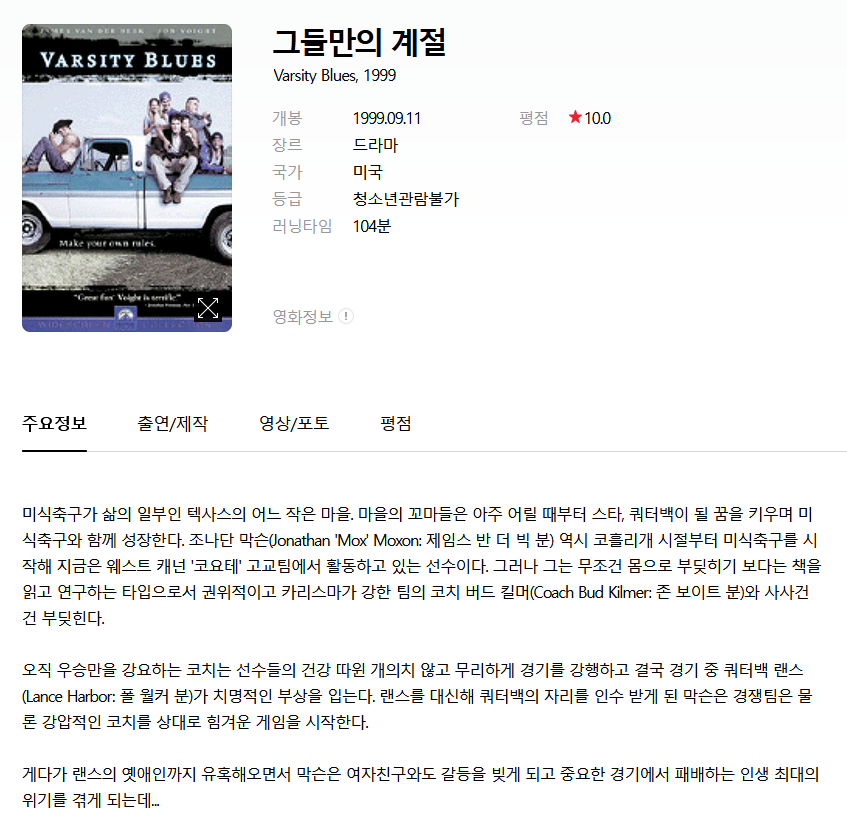 
(출처 : https://movie.daum.net/moviedb/main?movieId=3415)
* 내가 선호한다고 골랐던 영화와는 완전 다른 느낌의 영화였다. 
* 그런고로, 선호 영화들과의 수치가 올라갈 수록, varsity blues 와의 수치가 점점 낮아지는건 당연하다 볼 수 있겠다. 

================================== 첫번째 경우 (기본값) ============================================

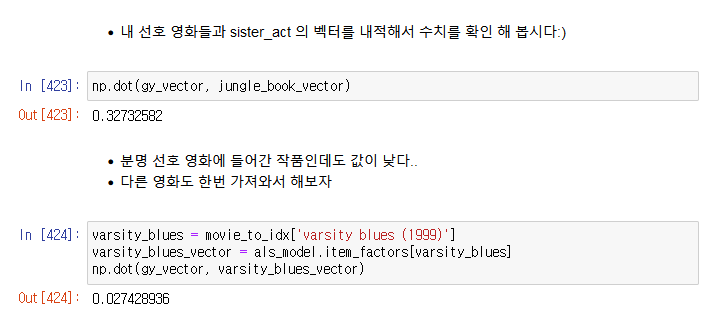
* 선호 목록에 있는 영화도 수치가 그리 좋지 못하게 나오는걸 보면, 무언가 부족한것같다. 
* AlternatingLeastSquares 의 파라미터 값을 변경해서 다시 시도해보자.   
    이대로 진행해도, 추천 영화가 만족스럽게 나오지 않을 것 같다.   
  기본값 : `factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)`

============================ 두번째 경우 (파라미터 변경)===========================================

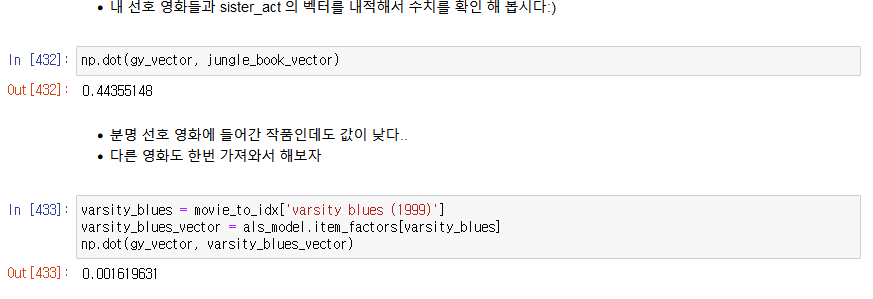  

2번째 경우 `factors=200, regularization=0.01, use_gpu=False, iterations=50, dtype=np.float32`  
* 내 선호 영화들과의 수치가 상승된것을 확인 할 수 있었지만, 목표치를 0.5 이상으로 잡고있기에, 파라미터값을 한번 더 수정해서 학습시켜 보기로 한다. 


============================ 세번째 경우 (파라미터 변경)===========================================

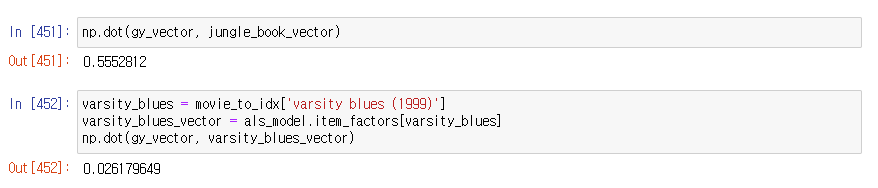  


세번째 경우 : `factors=300, regularization=0.01, use_gpu=False, iterations=150, dtype=np.float32`
* 벡터값, epoch 값을 대폭 늘려 학습을 진행해보았다. 
* 확실히 기본 값 보다 많은 학습이 진행 된 만큼, 만족스럽게 나온것 같다. 
* 이렇게 만들어진 모델로 영화를 추천 받아보자!

## &nbsp;&nbsp; 6-2 내가 좋아하는 영화와 비슷한 영화를 추천받기! 


* 학습시킨 모델에게 선호 영화와 비슷한 영화를 추천 받아보겠습니다. 

In [459]:
favorite_movie = 'sister act (1992)'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie


[(668, 1.0),
 (1586, 0.35753053),
 (567, 0.32607287),
 (3591, 0.31739777),
 (821, 0.3062695),
 (892, 0.27428102),
 (635, 0.25624824),
 (712, 0.25256157),
 (507, 0.24283238),
 (931, 0.2345308),
 (545, 0.23447458),
 (605, 0.22950806),
 (2833, 0.22709979),
 (341, 0.21662548),
 (555, 0.2104395)]

* (아티스트의 id, 유사도) 순.  Tuple 로 반환 되었습니다. 
* tuple을 다시 id, text 이름으로 매핑 시켜줍니다. 

In [460]:
#movie_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_artist]


['sister act (1992)',
 'sister act 2: back in the habit (1993)',
 'first wives club, the (1996)',
 "heaven's burning (1997)",
 'mrs. doubtfire (1993)',
 'in & out (1997)',
 'robin hood: men in tights (1993)',
 'to wong foo, thanks for everything! julie newmar (1995)',
 'home alone (1990)',
 'hocus pocus (1993)',
 'santa clause, the (1994)',
 'cool runnings (1993)',
 'shaggy d.a., the (1976)',
 'mighty ducks, the (1992)',
 'heart and souls (1993)']

* 위 과정을 몇번 더 반복 해 주기 위해 함수화 해봅니다. 

In [462]:
def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [464]:
get_similar_movie('toy story (1995)')

['toy story (1995)',
 'toy story 2 (1999)',
 "bug's life, a (1998)",
 'aladdin (1992)',
 'lion king, the (1994)',
 'soft toilet seats (1999)',
 'babe (1995)',
 'groundhog day (1993)',
 'wrong trousers, the (1993)',
 'beauty and the beast (1991)']

## &nbsp;&nbsp; 6-3 내가 좋아할만한 영화 추천 받기 


- `AlternatingLeastSquares` 클래스에 구현되어 있는 `recommend` 메서드를 통하여 제가 좋아할 만한 영화를 추천받습니다.
- `filter_already_liked_items`
    - 유저가 이미 평가한 아이템은 제외하는 Argument입니다.

In [465]:
user = user_to_idx['gy_jeong']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(547, 0.2665736),
 (23, 0.26131552),
 (45, 0.24125896),
 (191, 0.23419997),
 (821, 0.22799787),
 (46, 0.21076073),
 (572, 0.20831487),
 (8, 0.20385072),
 (551, 0.20217027),
 (567, 0.20080262),
 (1369, 0.19972497),
 (67, 0.19621497),
 (33, 0.19370946),
 (37, 0.18457665),
 (475, 0.18391974),
 (904, 0.181761),
 (520, 0.18006265),
 (626, 0.17923963),
 (559, 0.1767573),
 (341, 0.17527154)]

In [467]:
[idx_to_movie[i[0]] for i in movie_recommended]

['lady and the tramp (1955)',
 "schindler's list (1993)",
 'mary poppins (1964)',
 'little mermaid, the (1989)',
 'mrs. doubtfire (1993)',
 'dumbo (1941)',
 'sleeping beauty (1959)',
 'snow white and the seven dwarfs (1937)',
 'peter pan (1953)',
 'first wives club, the (1996)',
 '101 dalmatians (1996)',
 'gladiator (2000)',
 'aladdin (1992)',
 'cinderella (1950)',
 'my cousin vinny (1992)',
 'clockwork orange, a (1971)',
 "charlotte's web (1973)",
 "you've got mail (1998)",
 'robin hood (1973)',
 'mighty ducks, the (1992)']

* 디즈니 애니메이션을 기입했던 만큼, 101한마리 달마시안, 덤보와 같은 애니메이션 추천이 많다. 선호하는 영화와 비슷한영화, 좋아할만한 영화를 잘 추천해 준 것 같다. 
* 과제를 끝내놓고 신데렐라를 한번 봐야겠다ㅎㅎ:) 




---




# 후기!

* 이번 프로젝트로 인해, 넷플릭스나 디즈니 플러스 등의 스트리밍 사이트에서 어떤 식으로 우리에게 영상을 추천하는지 알 수 있었다.


* 진행 하고 나서 생각이 들었지만, 영화 제목(title)란에는 개봉년도가 함께 기재되어있는데, 이 부분을 컬럼을 만들어 분리시킨다거나, 전처리 과정에서 없애줬더라면, 영문 영화 제목만 기재해주면 되니, 일일이 영화 제목을 데이터셋 안에서 검색하거나, 이미 출력 된 영화 제목을 찾으러 가지 않아도 됬을것이다. 데이터 처리 할 때 한번 더 생각했었으면 좋았을걸.. 


* dataframe 다루기, 연습이 무지많이 필요하다.. 검색하고, 반복해서 하다보면 손에 익지않을..까..? 그러니 열심히 연습해보자구? 




---




# 🖇️참고페이지

* [프로젝트 전반 참고 자료](https://wikidocs.net/120609)


### dataframe 다루기 관련 


* [데이터 프레임 합치기](https://yganalyst.github.io/data_handling/Pd_12/)
* [데이터 프레임 행 추가](https://blog.naver.com/PostView.nhn?blogId=rising_n_falling&logNo=221629326893)